# ML-Leaks Adversary 3

## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

sys.path.insert(0, '../../../Utils/')

import models
from train import *
from metrics import * 

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 10
batch_size = 256
lr = 0.001



## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified


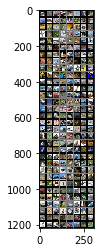

In [3]:
# define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    # have to pad a few pixels for resnet
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('../../../Datasets/', train=True, transform=transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('../../../Datasets/', train=False, transform=transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=100, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

## ML Leaks Adversary 3 (Membership Inference Attack) 
### https://arxiv.org/abs/1806.01246

In [4]:

total_size = len(cifar10_trainset)


indices = list(range(total_size))

split = total_size // 2
target_train_idx = indices[:split]
target_out_idx = indices[split:]



target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)



# the model being attacked (architecture can be different than shadow)
target_net = torchvision.models.resnet18(num_classes=10).to(device)
target_net.avgpool = nn.AvgPool2d(2, stride=1)
#target_net = models.mlleaks_cnn().to(device)

target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)





In [5]:
train(target_net, target_train_loader, cifar10_testloader, target_optim, target_loss, n_epochs, classes=classes)


[0/10]
Training:
Accuracy of airplane : 64.99 %
Accuracy of automobile : 81.45 %
Accuracy of bird : 48.07 %
Accuracy of cat : 46.55 %
Accuracy of deer : 51.69 %
Accuracy of dog : 35.21 %
Accuracy of frog : 76.59 %
Accuracy of horse : 57.67 %
Accuracy of ship : 67.25 %
Accuracy of truck : 40.02 %

Accuracy = 57.08 %


Test:
Accuracy of airplane : 63.40 %
Accuracy of automobile : 78.30 %
Accuracy of bird : 39.90 %
Accuracy of cat : 41.30 %
Accuracy of deer : 47.20 %
Accuracy of dog : 33.60 %
Accuracy of frog : 76.90 %
Accuracy of horse : 54.20 %
Accuracy of ship : 64.00 %
Accuracy of truck : 35.30 %

Accuracy = 53.41 %


[1/10]
Training:
Accuracy of airplane : 73.34 %
Accuracy of automobile : 92.18 %
Accuracy of bird : 43.18 %
Accuracy of cat : 53.41 %
Accuracy of deer : 38.23 %
Accuracy of dog : 49.23 %
Accuracy of frog : 79.98 %
Accuracy of horse : 57.55 %
Accuracy of ship : 81.33 %
Accuracy of truck : 60.35 %

Accuracy = 62.96 %


Test:
Accuracy of airplane : 67.70 %
Accuracy of autom

threshold = 0.5000, accuracy = 51.72, precision = 0.51, recall = 0.98
threshold = 0.5050, accuracy = 51.84, precision = 0.51, recall = 0.98
threshold = 0.5100, accuracy = 51.95, precision = 0.51, recall = 0.98
threshold = 0.5150, accuracy = 52.03, precision = 0.51, recall = 0.97
threshold = 0.5200, accuracy = 52.09, precision = 0.51, recall = 0.97
threshold = 0.5250, accuracy = 52.19, precision = 0.51, recall = 0.97
threshold = 0.5300, accuracy = 52.28, precision = 0.51, recall = 0.97
threshold = 0.5350, accuracy = 52.35, precision = 0.51, recall = 0.97
threshold = 0.5400, accuracy = 52.46, precision = 0.51, recall = 0.96
threshold = 0.5450, accuracy = 52.54, precision = 0.51, recall = 0.96
threshold = 0.5500, accuracy = 52.60, precision = 0.51, recall = 0.96
threshold = 0.5550, accuracy = 52.70, precision = 0.51, recall = 0.96
threshold = 0.5600, accuracy = 52.81, precision = 0.52, recall = 0.96
threshold = 0.5650, accuracy = 52.88, precision = 0.52, recall = 0.96
threshold = 0.5700, 

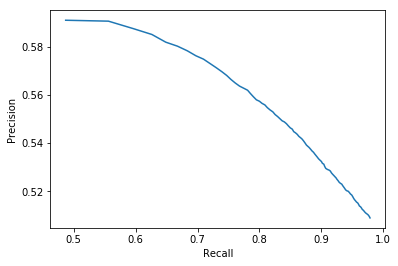

In [6]:
eval_membership_inference(target_net, target_train_loader, target_out_loader)